In [1]:
# Import libraries.
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d
import numpy as np
from numba import jit

%matplotlib inline

In [2]:
nx, ny = 41, 41
L = 1
delta = L / (nx - 1)
x = np.linspace(0.0, L, num=nx)
y = np.linspace(0.0, L, num=ny)

u0 = np.zeros((ny, nx))
u0[-1,:] = np.sin(3 * np.pi * x / 2 / L)
b = np.zeros((ny, nx))

In [3]:
@jit(nopython=True)
def poisson2d_jacobi(u0, b, maxiter=20000, rtol=1e-6):
    diff_jacobi = []
    u = u0.copy()     
    ny, nx = u.shape
    rdiff = rtol + 1
    ite = 0
    while rdiff > rtol and ite < maxiter:
        un = u.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                u[j, i] = 0.25 * (un[j - 1, i] +
                                  un[j, i - 1] +
                                  un[j, i + 1] +
                                  un[j + 1, i] -
                                  b[j, i])
        u[:,-1] = u[:,-2]
        rdiff = np.sqrt(np.sum((u - un)**2)) / np.sqrt(np.sum((un**2)))
        ite += 1
        diff_jacobi.append(rdiff)
    return u, diff_jacobi

In [4]:
def plot_3d(x, y, u, label='$z$', elev=30.0, azim=45.0):
    """Create a 3D surface plot of the scalar field `u`.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    u : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction; default: 'z'.
    elev : float, optional
        Elevation angle in the z plane; default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane; default: 45.0.

    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, u, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

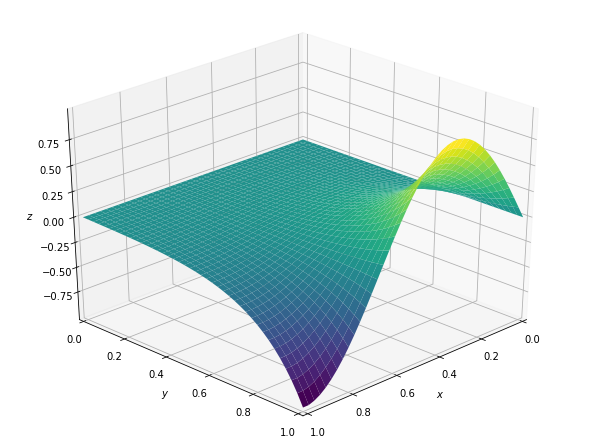

In [5]:
u_jacobi, diff_jacobi = poisson2d_jacobi(u0, b)
plot_3d(x, y, u_jacobi)

In [6]:
@jit(nopython=True)
def poisson2d_gauss(u0, b, maxiter=20000, rtol=1e-6):
    diff_gauss = []
    u = u0.copy()
    ny, nx = u.shape 
    rdiff = rtol + 1
    ite = 0
    while rdiff > rtol and ite < maxiter:
        un = u.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                u[j, i] = 0.25 * (u[j - 1, i] +
                                  u[j, i - 1] +
                                  un[j, i + 1] +
                                  un[j + 1, i] -
                                  b[j, i])
        u[:,-1] = u[:,-2]
        rdiff = np.sqrt(np.sum((u - un)**2)) / np.sqrt(np.sum((un**2)))
        ite += 1
        diff_gauss.append(rdiff)
    return u, diff_gauss

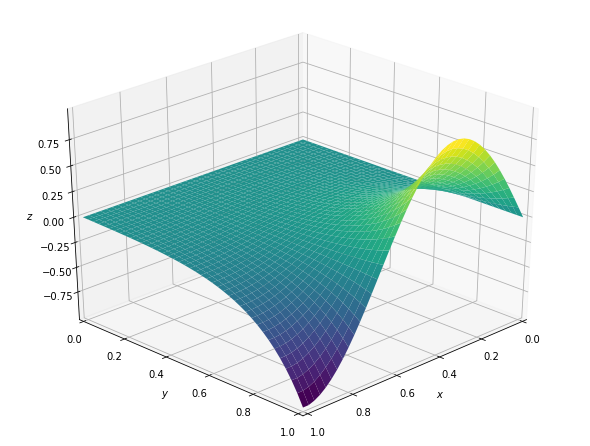

In [7]:
u_gauss, diff_gauss = poisson2d_gauss(u0, b)
plot_3d(x, y, u_gauss)

In [8]:
@jit(nopython=True)
def poisson2d_sor(u0, b, omega, maxiter=20000, rtol=1e-6):
    diff_sor = []
    u = u0.copy()
    ny, nx = u.shape
    rdiff = rtol + 1
    ite = 0
    while rdiff > rtol and ite < maxiter:
        un = u.copy()
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                u[j, i] = ((1 - omega) * u[j, i] + 
                           omega * 0.25 * (u[j - 1, i] + u[j, i - 1] + 
                                           u[j, i + 1] + u[j + 1, i] - b[j, i]))
        u[:,-1] = u[:,-2]
        rdiff = np.sqrt(np.sum((u - un)**2)) / np.sqrt(np.sum((un**2)))
        ite += 1
        diff_sor.append(rdiff)
    return u, diff_sor

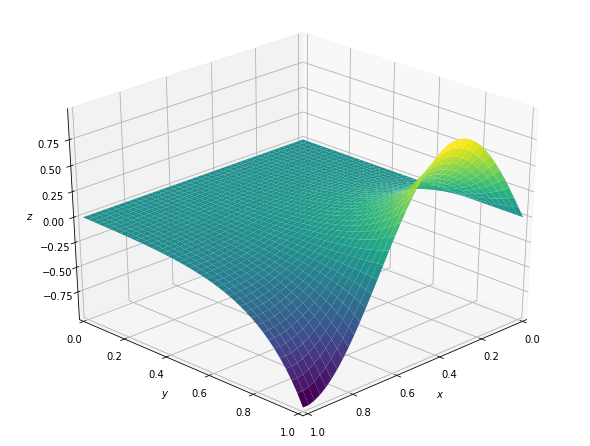

In [12]:
omega = 2.0 / (1.0 + np.pi / nx)
u_sor, diff_sor = poisson2d_sor(u0, b, omega)
plot_3d(x, y, u_sor)

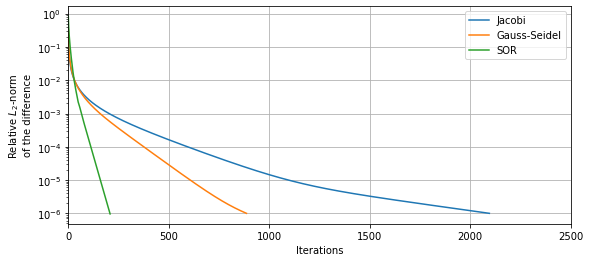

In [10]:
pyplot.figure(figsize=(9.0, 4.0))
pyplot.xlabel('Iterations')
pyplot.ylabel('Relative $L_2$-norm\nof the difference')
pyplot.grid()
pyplot.semilogy(diff_jacobi, label='Jacobi')
pyplot.semilogy(diff_gauss, label='Gauss-Seidel')
pyplot.semilogy(diff_sor, label='SOR')
pyplot.legend()
pyplot.xlim(0, 2500);